In [1]:
from fastai.text import * 

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/home/danywin/.fastai/data/imdb_sample')

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [4]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.341108,3.880856,0.285179,00:22


In [6]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.941490,3.806364,0.296607,00:29


In [7]:
learn.predict("This is a review about", n_words=10)

'This is a review about main character family events and how they are picked up'

In [8]:
learn.save_encoder('ft_enc')

In [9]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos a below average looking video game is turned into some sort of conspiracy to have the next terrorist discovered in the xxup usa backyard . xxmaj welcome to the xxunk of cheaply made direct to video movies . xxmaj its full of no - name actors and actresses with little valuable plot . 
 
  xxmaj anyway , this strange game goes on and our " hero " bets real money and does good at it . xxmaj it is sort of like gambling , except the gambling part is gone and it sucks . xxmaj instead its an online game with little real value and you get authorities on your tail if you do good . 
 
  xxmaj what makes it even stranger is that two strange computer programs battle it out somehow and all is saved in the end . i will leave the viewer to see how it all comes to xxunk . 
 
  xxmaj overall , not even worth a $ 1 rental . xxmaj borrow it , please . " xxup d- ",xxbos xxmaj this movie was absolutely wonderful . xxmaj the 

In [10]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.593814,0.575012,0.731343,00:21


In [11]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.496921,0.494161,0.786070,00:21


In [12]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.374430,0.396532,0.810945,00:39


In [13]:
from custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from bayesian import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

In [14]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8984, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8984, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): CustomDropout(p=0.2, activate=True)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(

In [35]:
switch_custom_dropout(learn.model,False,True)

Current active : True
Switching to : False
Current active : True
Switching to : False


In [36]:
pred,y = learn.get_preds()
accuracy(pred,y)

tensor(0.8109)

In [38]:
switch_custom_dropout(learn.model,True,True)

Current active : False
Switching to : True
Current active : False
Switching to : True


In [39]:
pred,y = get_preds_sample(learn)
accuracy(pred.mean(dim=0),y)

tensor(0.8159)

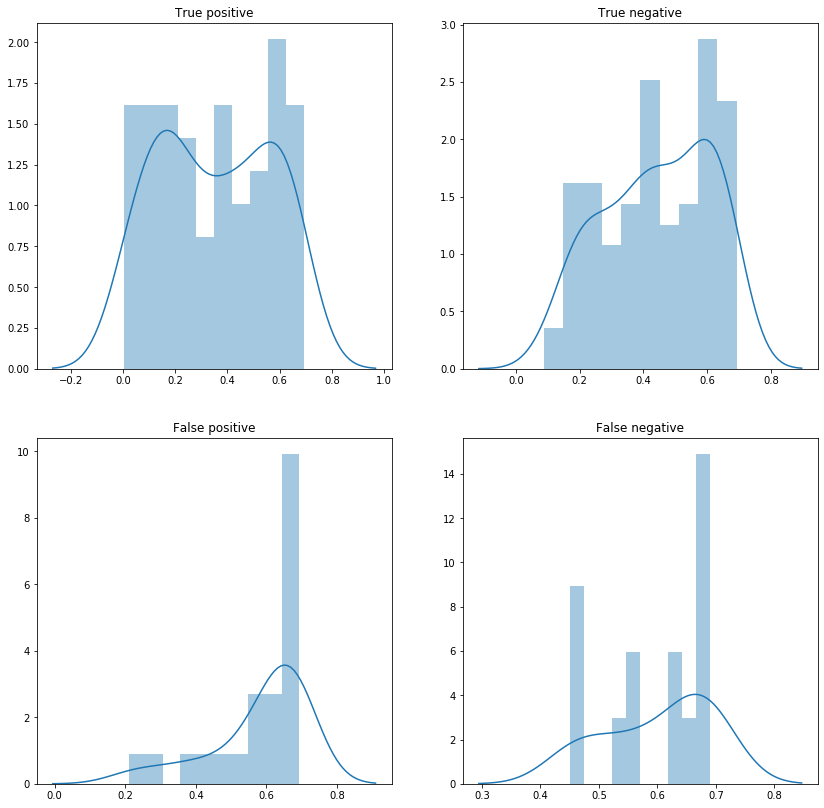

In [40]:
plot_hist_groups(pred,y,entropy,bins=10,figsize=(14,14))

In [45]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=False)
for review in learn.data.valid_ds[idx]:
    print("_____________")
    print("Review : ")
    print(review)

_____________
Review : 
(Text xxbos xxmaj not as bad a film as i thought it would be . 
 
  xxmaj it has a good cast . xxmaj nice to see xxmaj roger xxmaj moore back on screen as well as the use of other xxmaj british actors . 
 
  xxmaj would like to see more of xxmaj olivia d`abo in future projects . xxmaj maybe starring opposite her cousin the sexy xxmaj xxunk d`abo . 
 
  xxmaj also a good use of unseen locations such as xxmaj xxunk . 
 
  xxmaj hopefully we will see more xxup uk - xxmaj european co - productions like this ., Category positive)
_____________
Review : 
(Text xxbos xxmaj this is a worthless sequel to a great action movie . xxmaj cheap looking , and worst of all , xxup boring xxup action xxup scenes ! xxmaj the only decent thing about the movie is the last fight sequence . xxmaj only xxunk minutes , but it feels like it goes on forever ! xxmaj even die - hard xxmaj van xxmaj damme xxunk myself ) should avoid this one !, Category negative)
_____________
Review : 
(Text